In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem set 5

I had a bit of trouble installing `camb`, since I am on an Apple chip and have non-native python (i.e. x86 python) running for whatever reason. Rigel helped me get this up and running by installing a virtual environment and installing `camb` there with `conda create -n camb -c conda-forge python=3.9 camb`. That said, I don't know how to run Jupyter notebooks in virtual environments, so this notebook is more of a walkthrough of my procedure, with relevant code and results attached.

All relevant data and code files are in the `/mcmc` folder.

## 1)

Running `plank_likelihood.py` for the parameters already included, one obtains the result:

```
chisq is  15267.937968194292  for  2501  degrees of freedom.
```

This is *not* a good fit. We should expect a $\chi^2$ value near $<{\chi^2}> = n$ and within $\Delta \chi^2 = 2n$ where $n$ is the number of degrees of freedom. In this case, $n = 2501$ and therefore the $\chi^2$ does not fall within the expected value of $\chi^2$ provided the $n$ of this problem: $15267.93 \neq 2501 \pm 5002$. Therefore, the parameters dialed into the test script do not constitute a good fit.  

If we instead take ``` pars=np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95]) ```, we obtain

```
chisq is  3272.203604462886  for  2501  degrees of freedom.
```

This $\chi^2$ *is* within error to the expected $\chi^2$: $3272.203 = 2501 \pm 5002$ (don't worry about sig figs for now).

Here is an image of the fit, taken from the product of `planck_likelihood.py`:

![](mcmc/first_fit.png "Prelimiary fit")

## 2)

We'll now use Newton's method. In much the same way we did in problem set 4, the basic idea here is to start off with a guess of parameters and take the numerical derivatives with respect to these parameters to arrive at a better guess, and so on until convergence. Since we had a pretty good guess already in **1)**, we'll use that as our initial parameters. The code we use is shown below:

In [ ]:
import numpy as np
import camb

# define numerical derivative function

def ndiff2(fun,x,dx_ord=0):
    """
    Numerical derivative using both +/- dx and +/- 2*dx
    """
    # this is a fine choice for our purposes:
    # a) Newton's method will keep iterating until the solution is good and
    # b) our function and its derivatives are of order unity
    order = -3 + dx_ord
    dx = 10**(order)
    
    # compute the function at the points of interest
    yplus = fun(x + dx)
    yminus = fun(x - dx)
    yplus2 = fun(x + 2*dx)
    yminus2 = fun(x - 2*dx)
    
    # compute the numerical derivative
    fprime = (8 * yplus - yplus2 + yminus2 - 8 * yminus) / (12 * dx)
    
    return fprime

# define funcion to extract spectrum from camb
# this is more or less a black box
def get_spectrum(H0=0,ombh2=0,omch2=0,tau=0,As=0,ns=0,params=np.asarray([0,0,0,0,0,0]),lmax=3000,take_params=False):
    """
    Returns the spectrum for a given set of parameters H0, baryon density, dark matter density,
    optical depth, As, ns
    """
    if take_params:
        # define params
        H0=params[0]
        ombh2=params[1]
        omch2=params[2]
        tau=params[3]
        As=params[4]
        ns=params[5]

    # extract spectrum from camb
    # this is more or less a black box
    params=camb.CAMBparams()
    params.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    params.InitPower.set_params(As=As,ns=ns,r=0)
    params.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(params)
    powers=results.get_cmb_power_spectra(params,CMB_unit='muK') # <- this is where we get the data
    cmb=powers['total']
    tt=cmb[:,0]

    return tt[2:]

# define gradient helper function
# make sure to rescale the optimal dx by the parameter's order
def params_grad(fun,params):
    """
    Returns the numerical derivative at points `params` in parameter space
    """
    H0, ombh2, omch2, tau, As, ns = params
    
    # derivative w.r.t H0 at p
    fun_H00 = lambda H00: fun(H00,ombh2,omch2,tau,As,ns)
    grad_H0 = ndiff2(fun_H00,H0,dx_ord=+1)
    
    # derivative w.r.t ombh2 at p
    fun_ombh22 = lambda ombh22: fun(H0,ombh22,omch2,tau,As,ns)
    grad_ombh2 = ndiff2(fun_ombh22,ombh2,dx_ord=-2)

    # derivative w.r.t omch2 at p
    fun_omch22 = lambda omch22: fun(H0,ombh2,omch22,tau,As,ns)
    grad_omch2 = ndiff2(fun_omch22,omch2,dx_ord=-1)

    # derivative w.r.t tau at p
    fun_tauu = lambda tauu: fun(H0,ombh2,omch2,tauu,As,ns)
    grad_tau = ndiff2(fun_tauu,tau,dx_ord=-2)

    # derivative w.r.t As at p 
    fun_Ass = lambda Ass: fun(H0,ombh2,omch2,tau,Ass,ns) # sorry for the profanity
    grad_As = ndiff2(fun_Ass,As,dx_ord=-9)

    # derivative w.r.t ns at p
    fun_nss = lambda nss: fun(H0,ombh2,omch2,tau,As,nss)
    grad_ns = ndiff2(fun_nss,ns,dx_ord=0)

    # transpose to make it match with calc_lorentz
    return np.array([grad_H0, grad_ombh2, grad_omch2, grad_tau, grad_As, grad_ns]).T 

    # return np.array([grad_H0, grad_ombh2, grad_omch2, ]).T

# define newtons method iterator
def newtons_method(p0,d,num,print_params=False):
    """
    Numerical derivative version of `newtons_method`
    Runs Newton's method for initial parameter guess p0
    t and d are the time and data, resp.
    """
    # starting parameters is p0
    p = p0.copy()

    for i in range(num):
        # calculate derivatives and function
        pred = get_spectrum(params=p,take_params=True)
        pred = pred[:len(d)] # make both the same size (we don't want to extrapolate)
        grad = params_grad(fun=get_spectrum,params=p)
        grad = grad[:len(d)]

        # delta is difference between data and prediction
        r = d - pred
        err = (r**2).sum()
        r = r.T
        
        lhs=grad.T@grad
        rhs=grad.T@r
        dp=np.linalg.pinv(lhs)@(rhs)
        for jj in range(p.size):
            p[jj]=p[jj]+dp[jj]
                        
        if print_params:
            print("The parameters are:",p)
            print("The step is:",dp)
    
    return p, dp

# run the "main"
if __name__ == '__main__':
    # extract data from .txt files
    planck = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
    ell = planck[:,0]
    spec = planck[:,1]
    errs = (planck[:,2] + planck[:,3]) / 2
    
    # initial guess and no. of iterations
    p0 = np.asarray([69,0.022,0.12,0.06,2.1e-9,0.95])
    num_iter = 5
    
    # run the iterator
    params_newton, step = newtons_method(p0=p0,d=spec,num=num_iter,print_params=True)
    
    # estimate the uncertainties
    pred = get_spectrum(params=params_newton,take_params=True)
    pred = pred[:len(spec)]
    Ninv = np.linalg.inv(np.diag(errs))
    
    # parameter errors
    grad = params_grad(fun=get_spectrum,params=params_newton) # use differential gradient
    grad = grad[:len(spec)]
    lhs = grad.T@Ninv@grad
    par_errs = np.sqrt(np.diag(np.linalg.inv(lhs)))
    print("The errors are {}".format(par_errs))
    
    np.savetxt("planck_fit_params.txt", np.array([params_newton, par_errs]).T)

When run in the `camb` environment, it returns, after 5 iterations:
```
The parameters are: [6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779228e-09 9.50000000e-01]
The step is: [-5.21713904e-23  2.90831665e-19 -1.50903574e-19 -7.43590788e-20
  1.77922838e-11 -1.97538604e-20]
The parameters are: [6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779231e-09 9.50000000e-01]
The step is: [-9.20879475e-29  5.13388256e-25 -2.66392826e-25 -1.31262655e-25
  3.11437060e-17 -3.48715248e-26]
The parameters are: [6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779231e-09 9.50000000e-01]
The step is: [ 9.08377570e-34 -5.06418471e-30  2.62776264e-30  1.29480626e-30
 -3.07208971e-22  3.43981073e-31]
The parameters are: [6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779231e-09 9.50000000e-01]
The step is: [ 1.11316243e-34 -6.20585571e-31  3.22016610e-31  1.58670771e-31
 -3.76466237e-23  4.21528250e-32]
The parameters are: [6.90000000e+01 2.20000000e-02 1.20000000e-01 6.00000000e-02
 2.11779231e-09 9.50000000e-01]
The step is: [-1.20182285e-35  6.70013562e-32 -3.47664374e-32 -1.71308474e-32
  4.06450769e-24 -4.55101852e-33]
The errors are [1.16828605e-01 2.20474064e-05 2.54033954e-04 3.63097430e-03
 1.46372787e-11 6.88626237e-04]
```

The best fit parameters and errors are therefore:


In [79]:
newton = np.loadtxt("mcmc/planck_fit_params.txt")
params_newton = newton[:,0]
param_errs_newton = newton[:,1]

In [80]:
print("H0 = {} +/- {}".format(params_newton[0],param_errs_newton[0]))
print("Omegabh2 = {} +/- {}".format(params_newton[1],param_errs_newton[1]))
print("Omegach2 = {} +/- {}".format(params_newton[2],param_errs_newton[2]))
print("tau = {} +/- {}".format(params_newton[3],param_errs_newton[3]))
print("As = {} +/- {}".format(params_newton[4],param_errs_newton[4]))
print("ns = {} +/- {}".format(params_newton[5],param_errs_newton[5]))

H0 = 69.0 +/- 0.11682860476516188
Omegabh2 = 0.022 +/- 2.204740636442771e-05
Omegach2 = 0.12 +/- 0.00025403395375825035
tau = 0.06 +/- 0.003630974299487817
As = 2.1177923149017066e-09 +/- 1.463727873635012e-11
ns = 0.95 +/- 0.0006886262373866526


Note: I know that something isn't quite right here, since none of the parameters are really varying. I think this has to do with either a bug in the differentiator (which would be odd, since it worked for PS4) or due to me not accounting for errors on the data through the matrix `N` which I ommitted in the Newton's method algorithm (which still should not mean that the parameters don't at all change, however). I believe it is more likely the latter, since in this case one must treat the `camb` model as a black box of sorts, and it is therefore difficult to assess whether or not the model and its derivatives are accurate.

## 3)

Let's try to get to the optimal parameters via an MCMC method. We know how to do this from the previous problem set, so let's just go ahead and implement it:

In [ ]:
import numpy as np
import camb
import time

# to get spectrum (model) from CAMB parameters 
def get_spectrum(H0=0,ombh2=0,omch2=0,tau=0,As=0,ns=0,params=np.asarray([0,0,0,0,0,0]),lmax=3000,take_params=False):
    """
    Returns the spectrum for a given set of parameters H0, baryon density, dark matter density,
    optical depth, As, ns
    """
    if take_params:
        # define params
        H0=params[0]
        ombh2=params[1]
        omch2=params[2]
        tau=params[3]
        As=params[4]
        ns=params[5]

    # extract spectrum from camb
    params=camb.CAMBparams()
    params.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    params.InitPower.set_params(As=As,ns=ns,r=0)
    params.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(params)
    powers=results.get_cmb_power_spectra(params,CMB_unit='muK') # <- this is where we get the data
    cmb=powers['total']
    tt=cmb[:,0]

    return tt[2:]

# to reproduce the curvature matrix from the previous problem
def ndiff2(fun,x,dx_ord=0):
    """
    Numerical derivative using both +/- dx and +/- 2*dx
    """
    # this is a fine choice for our purposes:
    # a) Newton's method will keep iterating until the solution is good and
    # b) our function and its derivatives are of order unity
    order = -3 + dx_ord
    dx = 10**(order)
    
    # compute the function at the points of interest
    yplus = fun(x + dx)
    yminus = fun(x - dx)
    yplus2 = fun(x + 2*dx)
    yminus2 = fun(x - 2*dx)
    
    # compute the numerical derivative
    fprime = (8 * yplus - yplus2 + yminus2 - 8 * yminus) / (12 * dx)
    
    return fprime
def params_grad(fun,params):
    """
    Returns the numerical derivative at points `params` in parameter space
    """
    H0, ombh2, omch2, tau, As, ns = params
    
    # derivative w.r.t H0 at p
    fun_H00 = lambda H00: fun(H00,ombh2,omch2,tau,As,ns)
    grad_H0 = ndiff2(fun_H00,H0,dx_ord=+1)
    
    # derivative w.r.t ombh2 at p
    fun_ombh22 = lambda ombh22: fun(H0,ombh22,omch2,tau,As,ns)
    grad_ombh2 = ndiff2(fun_ombh22,ombh2,dx_ord=-2)

    # derivative w.r.t omch2 at p
    fun_omch22 = lambda omch22: fun(H0,ombh2,omch22,tau,As,ns)
    grad_omch2 = ndiff2(fun_omch22,omch2,dx_ord=-1)

    # derivative w.r.t tau at p
    fun_tauu = lambda tauu: fun(H0,ombh2,omch2,tauu,As,ns)
    grad_tau = ndiff2(fun_tauu,tau,dx_ord=-2)

    # derivative w.r.t As at p 
    fun_Ass = lambda Ass: fun(H0,ombh2,omch2,tau,Ass,ns) # sorry for the profanity
    grad_As = ndiff2(fun_Ass,As,dx_ord=-9)

    # derivative w.r.t ns at p
    fun_nss = lambda nss: fun(H0,ombh2,omch2,tau,As,nss)
    grad_ns = ndiff2(fun_nss,ns,dx_ord=0)

    # transpose to make it match with calc_lorentz
    return np.array([grad_H0, grad_ombh2, grad_omch2, grad_tau, grad_As, grad_ns]).T 

# computes chi squared
def chisquared(d,pred,errs):
    """
    Computes chi-squared given some data d and pred
    In our case, errs is a constant and is always the same
    """
    chi2 = np.sum((pred-d)**2/errs**2)
    
    return chi2

# takes a random step in parameter space
def random_step(cov):
    """
    Random Gaussian step in each parameter
    """
    scale = 0.9 # manually adjusted scale factor
    
    cov = cov/scale
    
    step = np.random.multivariate_normal(np.zeros(cov.shape[0]),cov)
    
    return step

# performs a mcmc step  
def mcmc_step(d,params,chisq,cov,errs):
    """
    Single step in MCMC chain
    Params is a vector 
    Param_errs is the covariance in the initial parameters in the 
    """
    # compute a set of new trial parameters 
    new_params = params + random_step(cov)
    
    # they predict the following data
    new_pred = get_spectrum(params=new_params,take_params=True)[:len(d)]
    
    # this data has the following chi squared
    new_chisq = chisquared(d,new_pred,errs)
    
    # if it improves the chi squared, always accept
    # if not, accept it with a probability exp(-1/2* ((x^2)new - (x^2)old))
    log_accept_prob = -1/2*(new_chisq - chisq)
    
    # make it a log to avoid computing exponentials
    if np.log(np.random.rand(1)) < log_accept_prob:
        return new_params, new_chisq
    else:
        return params, chisq

# main mcmc function
def mcmc_main(d,initial_params,cov,errs,nstep=20000):
    """
    Main function for the MCMC chain
    """
    # initialize chain
    n = initial_params.size
    chain_params = np.zeros((nstep,n),dtype=float)
    chain_params[0,:] = initial_params
    
    # compute initial chi squared
    pred = get_spectrum(params=initial_params,take_params=True)[:len(d)]
    initial_chisq = chisquared(d,pred,errs)
    chain_chisq = np.zeros(nstep,dtype=float)
    chain_chisq[0] = initial_chisq
            
    # take `nstep` number of steps
    for i in range(1,nstep):
        # get the old parameters
        params = chain_params[i-1,:]
        chisq = chain_chisq[i-1]
        # compute the putatively new ones
        params_, chisq_ = mcmc_step(d,params,chisq,cov,errs)
        # put them into the chain
        chain_params[i,:] = params_
        chain_chisq[i] = chisq_
        
    return chain_params, chain_chisq

# code to run on terminal in camb environment
if __name__ == '__main__':
    # import data
    planck = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
    ell = planck[:,0]
    spec = planck[:,1]
    errs = (planck[:,2] + planck[:,3]) / 2

    # initial guess
    p0 = np.asarray([69,0.022,0.12,0.054,2.1e-9,0.95])

    # get model spectrum
    pred = get_spectrum(params=p0,take_params=True)
    pred = pred[:len(spec)]
    params_newton = np.loadtxt('planck_fit_params.txt')[:,0] # for curvature matrix of previous problem
    grad = params_grad(fun=get_spectrum,params=params_newton)
    grad = grad[:len(spec)]

    # covariance matrix
    Ninv = np.linalg.inv(np.diag(errs**2))
    lhs = grad.T@Ninv@grad
    cov = np.linalg.inv(lhs)

    # run the mcmc simulation
    nsteps = 10000 # takes O(1) second per step, so this should take ~3 hours
    t1 = time.time()
    chain_params, chain_chisq = mcmc_main(d=spec,initial_params=p0,cov=cov,errs=errs,nstep=nsteps)
    t2 = time.time()

    # save the data
    data = np.zeros((nsteps,7))
    data[:,0] = chain_chisq
    data[:,1:] = chain_params
    np.savetxt("planck_chain.txt", data)

    # report time
    print("Time it took to do {} MCMC steps:{}".format(nsteps,t2-t1))

The resulting chains are saved in the files:

In [2]:
planck_mcmc_data = np.loadtxt("mcmc/planck_chain.txt")
planck_chain = planck_mcmc_data[:,1:]
planck_chisq = planck_mcmc_data[:,0]

Which, at first glance, yield the putative convergences:

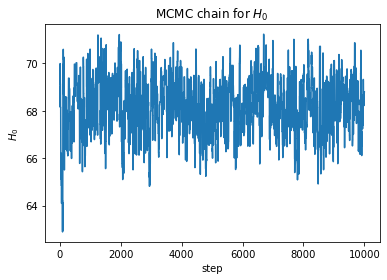

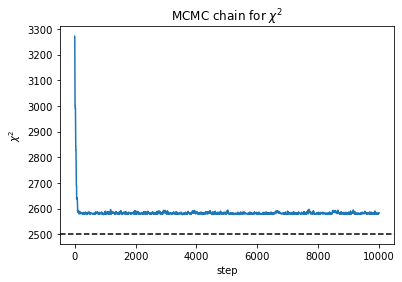

In [246]:
x = np.arange(10000)

plt.figure()
plt.title(r"MCMC chain for $H_0$")
plt.ylabel("$H_0$")
plt.xlabel("step")
plt.plot(x,planck_chain[:,0])
plt.show()

plt.figure()
plt.title(r"MCMC chain for $\chi^2$")
plt.ylabel("$\chi^2$")
plt.xlabel("step")
plt.plot(x,planck_chisq)
plt.axhline(2501,c='k',ls='--')
plt.show()

So, did the values converge? Hard to say. Judging by the upper plot of $H_0$ as a function of MCMC steps, I would say that **no, the MCMC algorithm has not converged**. Retracing back our steps, I think this is due to a bug in my original Newton's method iterator (which is odd, since this code worked fine for all other problem sets and I still cannot seem to find the bug after many attempts and building a minimal model to test it -- however, since the `get_spectrum` function is more or less a black box, testing our `grad_params` function on it is not very enlightening). This in turn yields a faulty covariance matrix which trickles down into our MCMC algorithm, providing dubious new test parameters. I have done my best to attempt to remedy this by tweaking the step with an overall scale factor of order unity (as was done in problem set 4) and varying the way in which steps are taken (e.g. trying out a uniform distribution) but the results are qualitatively the same. The trial and error method proved at least somewhat effective, as it yielded a $<\chi^2> \approx n = 2501$, but this method is time-intensive, since every trial takes an order of six hours. So, **I do not think my chains are converged**, and I can trace back the cause to the erroneous covariance matrix obtained via Newton's method stemming from a bug (which I have not discovered due to the black box nature of `get_spectrum` not liking `grad_params` though not without much toil) when `grad_params` acts on `get_spectrum`. 

Moving on as though everything had worked, what are the values and their errors?

In [244]:
# set a burn-in time
burnin = 100 # more or less

# these are the best parameters (again, assuming convergence)
mcmc_params = planck_chain[-1,:]

# the error is simply the standard deviation of the sample
sigma_mcmc_params = np.std(planck_chain[burnin:,:],axis=0)

print("H0 = {} +/- {}".format(mcmc_params[0],sigma_mcmc_params[0]))
print("Omegabh2 = {} +/- {}".format(mcmc_params[1],sigma_mcmc_params[1]))
print("Omegach2 = {} +/- {}".format(mcmc_params[2],sigma_mcmc_params[2]))
print("tau = {} +/- {}".format(mcmc_params[3],sigma_mcmc_params[3]))
print("As = {} +/- {}".format(mcmc_params[4],sigma_mcmc_params[4]))
print("ns = {} +/- {}".format(mcmc_params[5],sigma_mcmc_params[5]))

H0 = 68.80375944904863 +/- 1.0872354015286563
Omegabh2 = 0.02221693293836467 +/- 0.00020751209881565068
Omegach2 = 0.11650370781229581 +/- 0.002436431723053146
tau = 0.09546878602718682 +/- 0.02604136802420618
As = 2.264039671665958e-09 +/- 1.0923033350069017e-10
ns = 0.9745173040304714 +/- 0.005852441622004641


Again, I'm fairly certain this isn't correct. Indeed, the error in some values ($H_0$ and $\tau$) is on the same order as the first significant figure. Also, the value of $\tau$ is significantly off from our initial guess and the value presented in question **4)**. One redeeming feature is that $\Omega_{b,c} h^2$ seem to have a reasonably good (samll) error with respect to their value. Looking at their MCMC chains, we can see that their convergence is once again not complete:

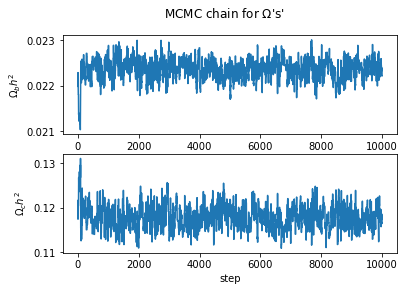

In [245]:
fig,ax=plt.subplots(nrows=2)
plt.suptitle(r"MCMC chain for $\Omega$'s'")
ax[0].set_ylabel("$\Omega_b h^2$")
ax[1].set_ylabel("$\Omega_c h^2$")
ax[1].set_xlabel("step")
ax[0].plot(x,planck_chain[:,1])
ax[1].plot(x,planck_chain[:,2])
plt.show()


In the interest of completing this assignment, however, we move on yet. The value of $h$ is extracted from $H_0$ as such:

In [162]:
h=planck_chain[-1,0]/100

We may now solve for $\Omega_{\Lambda}$ using $1 =\Omega_{\Lambda}+\Omega_{b}+\Omega_{c} $. We use a mini monte-carlo (not mcmc) method to propagate errors (i.e. create a bunch of Gaussian distributed samples centred at the mean with deviation equal to the error, and get the final error by computing the standard deviation of the total).

In [189]:
# set up the means and standard deviations
lots = 10000
H0 = mcmc_params[0]
H0_sigma = sigma_mcmc_params[0]
omega_bh = mcmc_params[1]
omega_bh_sigma = sigma_mcmc_params[1]
omega_ch = mcmc_params[2]
omega_ch_sigma = sigma_mcmc_params[2]

# set up the normally distributed arrays
H0s = np.random.normal(loc=H0, scale=H0_sigma, size=lots)
omega_bhs = np.random.normal(loc=omega_bh, scale=omega_bh_sigma, size=lots)
omega_chs = np.random.normal(loc=omega_ch, scale=omega_ch_sigma, size=lots)

# calculate everything
hs = H0s / 100
omega_lambdas = 1 - omega_bhs / hs**2 - omega_bhs / hs**2
omega_lambda = np.mean(omega_lambdas)
omega_lambda_sigma = np.std(omega_lambdas)

# print it
print("Omega_Lambda is: {} +/- {}".format(omega_lambda,omega_lambda_sigma))

Omega_Lambda is: 0.906105480381642 +/- 0.003079592729882093


So we have obtained $\Omega_{\Lambda} = 0.906(3)$.

## 4)

We will now repeat the MCMC procedure of the last problem, however with the additional constraint that $\tau = 0.054 \pm 0.0074$. We include this constraint simply by adding a term in our $\chi^2$ of the form `chisq_tau = ((trial_tau-tau_prior)/(sigma_tau_prior))**2` where `tau_prior +/- sigma_tau_prior` = $0.054 \pm 0.0074$. This can be thought of as an additional model constraint (we have an updated prior, if you will). So, let's run a new chain with this constraint:

In [ ]:
# this is the only part of the code that changes

# performs a mcmc step  
def mcmc_step(d,params,chisq,cov,errs):
    """
    Single step in MCMC chain
    Params is a vector 
    Param_errs is the covariance in the initial parameters in the 
    """
    # set constrained parameters
    tau_prior = 0.0540
    sigma_tau_prior = 0.0074

    # compute a set of new trial parameters 
    new_params = params + random_step(cov)
    
    # they predict the following data
    new_pred = get_spectrum(params=new_params,take_params=True)[:len(d)]
    
    # this data has the following chi squared
    # include the constraint that tau = tau_prior +/- sigma_tau_prior
    tau_chisq = ((new_params[3] - tau_prior)/sigma_tau_prior)**2
    new_chisq = chisquared(d,new_pred,errs) + tau_chisq
    
    # if it improves the chi squared, always accept
    # if not, accept it with a probability exp(-1/2* ((x^2)new - (x^2)old))
    log_accept_prob = -1/2*(new_chisq - chisq)
    
    # make it a log to avoid computing exponentials
    if np.log(np.random.rand(1)) < log_accept_prob:
        return new_params, new_chisq
    else:
        return params, chisq

In [69]:
data_tauprior = np.loadtxt("mcmc/planck_chain_tauprior.txt")
planck_chain_tau = data_tauprior[:,1:]
planck_chisq_tau = data_tauprior[:,0]

# the params are the last site
mcmc_params_tau = planck_chain_tau[-1,:]

# the errors are the standard deviation of the chain
sigma_mcmc_params_tau = np.std(planck_chain_tau[burnin:,:], axis=0)

Let's have a quick look at convergence:

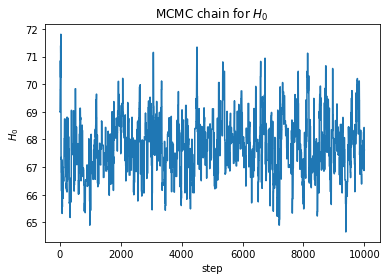

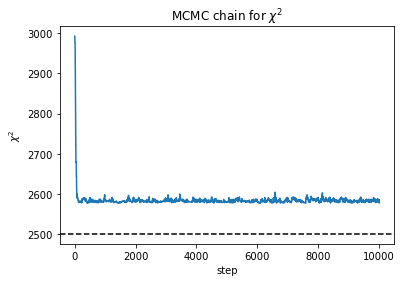

In [240]:
x = np.arange(10000)

plt.figure()
plt.title(r"MCMC chain for $H_0$")
plt.plot(x,planck_chain_tau[:,0])
plt.ylabel("$H_0$")
plt.xlabel("step")
plt.show()

plt.figure()
plt.title(r"MCMC chain for $\chi^2$")
plt.ylabel("$\chi^2$")
plt.xlabel("step")
plt.plot(x,planck_chisq_tau)
plt.axhline(2501,c='k',ls='--')
plt.show()

The same problems as before are inherited here as well. These are the parameters we obtain:

In [237]:
print("H0 = {} +/- {}".format(mcmc_params_tau[0],sigma_mcmc_params_tau[0]))
print("Omegabh2 = {} +/- {}".format(mcmc_params_tau[1],sigma_mcmc_params_tau[1]))
print("Omegach2 = {} +/- {}".format(mcmc_params_tau[2],sigma_mcmc_params_tau[2]))
print("tau = {} +/- {}".format(mcmc_params_tau[3],sigma_mcmc_params_tau[3]))
print("As = {} +/- {}".format(mcmc_params_tau[4],sigma_mcmc_params_tau[4]))
print("ns = {} +/- {}".format(mcmc_params_tau[5],sigma_mcmc_params_tau[5]))

H0 = 67.61733091750979 +/- 1.0394051189437972
Omegabh2 = 0.02229257109929826 +/- 0.00021165372624995315
Omegach2 = 0.11934489549145502 +/- 0.002360128663603689
tau = 0.05415361478650203 +/- 0.007222597642066387
As = 2.0933171769615404e-09 +/- 3.148098100992451e-11
ns = 0.9688233530956443 +/- 0.0060204364942864795


Next we want to do importance sampling on the chain of the last problem with the additional $\delta\chi^2$ term (stemming from the contraint of $\tau$) acting as the effective weight and compare our results to those obtained by running a whole new chain. The code is as follows:

In [ ]:
# import data
planck = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell = planck[:,0]
spec = planck[:,1]
errs = (planck[:,2] + planck[:,3]) / 2

# import chains
planck_chain = np.loadtxt("planck_chain.txt")
planck_chisq = np.loadtxt("planck_chisq.txt")

# define the new parameter value
tau_prior = 0.0540
sigma_tau_prior = 0.0074

# compute the new chi2 (effective weight)
# i.e. just the difference in our old taus and the new constrained one
tau_chain = planck_chain[:,3]
planck_chisq_new =  ((tau_prior-tau_chain)/sigma_tau_prior)**2

# with this new chisquared, compute the new phase-space density L'/L
density = np.exp(-0.5 * (planck_chisq_new))

# compute the new parameters as weighted sums
density_all = np.tile(density,(planck_chain.shape[1],1)).T / np.sum(density)
params_weighted = np.sum(density_all * planck_chain, axis=0)

# save the data
np.savetxt("planck_chisq_new.txt", planck_chisq_new)
np.savetxt("planck_density.txt", density)
np.savetxt("planck_params_weighted.txt", params_weighted)

Running this, we obtain the new values for the parameters. We should also re-calculate the errors by taking the deviation of our new weighted chains.

In [233]:
planck_chain_weighted = np.loadtxt("mcmc/planck_chain_weighted.txt")
sigma_mcmc_params_sampling = np.std(planck_chain_weighted[burnin:,:], axis=0)

In [234]:
mcmc_params_sampling = np.loadtxt("mcmc/planck_params_weighted.txt")

print("H0 = {} +/- {}".format(mcmc_params_sampling[0],sigma_mcmc_params_sampling[0]))
print("Omegabh2 = {} +/- {}".format(mcmc_params_sampling[1],sigma_mcmc_params_sampling[1]))
print("Omegach2 = {} +/- {}".format(mcmc_params_sampling[2],sigma_mcmc_params_sampling[2]))
print("tau = {} +/- {}".format(mcmc_params_sampling[3],sigma_mcmc_params_sampling[3]))
print("As = {} +/- {}".format(mcmc_params_sampling[4],sigma_mcmc_params_sampling[4]))
print("ns = {} +/- {}".format(mcmc_params_sampling[5],sigma_mcmc_params_sampling[5]))

H0 = 67.74424541340402 +/- 0.013309517671281714
Omegabh2 = 0.02229725956920926 +/- 4.382703584355666e-06
Omegach2 = 0.11885896308837077 +/- 2.3329578410434945e-05
tau = 0.05564797628049732 +/- 1.0733976064574594e-05
As = 2.097294119685432e-09 +/- 4.1077369345718416e-13
ns = 0.970646350573181 +/- 0.00019068989770073766


The values of $H_0$, $\Omega_b h^2$, $\Omega_c h^2$, and $A_s$ are consistent with running the entire chain again with a modified $\chi^2$ to account for the $\tau$ constraint. The values of $\tau$ and $n_s$ are not, however.